<center><font size=+1.5><b>PRIMO PROGETTO DI MACHINE LEARNING </b></font></center>

In questo primo progetto sperimento le tecniche base di Machine Learning appena apprese. <br>
Poichè il dataset usato è molto semplice e non ha bisogno di una particolare preparazione, salto la fase di EDA e mi concentro solo sull'addestramento e la validazione dell'algoritmo SVC.

##  DATASET WINE

In [1]:
#importo le librerie di base
import numpy as np
import pandas as pd

In [2]:
#scarico il dataset dei vini da sklearn e dò un'occhiata alla descrizione fornita
from sklearn import datasets
wine = datasets.load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Il dataset continete 178 campioni di analisi chimiche di vini appartenenti a 3 diverse classi (si tratta quindi di un problema di <i> CLASSIFICAZIONE) </i>. <br>
Ogni campione è descritto da 13 features. <br>
Le classi sono così distribuite: class_0 (59), class_1 (71), class_2 (48) <br>
Non ci sono valori nulli.

Con Pandas creo un dataframe per visualizzare i dati in un modo più ordinato e controllare la corrispondenza con la descrizione fornita:

In [3]:
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df = pd.concat([df, pd.DataFrame(wine.target)], axis=1).rename(columns={0: "label"})
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
np.bincount(df["label"])

array([59, 71, 48], dtype=int64)

In [5]:
#controllo la rappresentanza percentuale delle classi
count = df["label"].value_counts()
round(count/count.sum()*100, 2)

1    39.89
0    33.15
2    26.97
Name: label, dtype: float64

La classe che prevale è la 1 ma non ci sono squilibri problematici.

In [6]:
#controllo che non ci siano valori nulli
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  label

In [7]:
#controllo massimi e minimi:
print("Min:\n")
print(np.min(df.drop("label", axis=1), axis=0))
print("\nMax:\n")
print(np.max(df.drop("label", axis=1), axis=0))

Min:

alcohol                          11.03
malic_acid                        0.74
ash                               1.36
alcalinity_of_ash                10.60
magnesium                        70.00
total_phenols                     0.98
flavanoids                        0.34
nonflavanoid_phenols              0.13
proanthocyanins                   0.41
color_intensity                   1.28
hue                               0.48
od280/od315_of_diluted_wines      1.27
proline                         278.00
dtype: float64

Max:

alcohol                           14.83
malic_acid                         5.80
ash                                3.23
alcalinity_of_ash                 30.00
magnesium                        162.00
total_phenols                      3.88
flavanoids                         5.08
nonflavanoid_phenols               0.66
proanthocyanins                    3.58
color_intensity                   13.00
hue                                1.71
od280/od315_of_diluted_wi

Ci sono feature che hanno valori massimi e minimi assoluti molto più grandi delle altre (come ad esempio "proline").
Poichè userò l'algoritmo SVM (in questo caso specifico SVC) per la classificazione, devo scalare questi valori in modo che ogni feature abbia lo stesso peso nella ricerca del miglior margine di separazione.

In [8]:
#prima di tutto divido il dataset in training e test. 
#Per mantenere il rapporto di distribuzione delle classi, assegno a "stratify" l'array delle labels
y = df["label"]
X = df.iloc[:,:-1]

from sklearn.model_selection import train_test_split as split
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, shuffle=True, random_state=0, stratify=y)

#scalo i dati per uniformare minimi e massimi di ogni feature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#per non "barare" faccio il fitting dello scaler sui soli dati di training
#sul training test faccio fit e transform contemporaneamente
X_train = scaler.fit_transform(X_train)

#ora che lo scaler è stato addestrato sui dati di training, faccio il transform sui dati di test
X_test = scaler.transform(X_test)

Per validare gli iperparametri di SVC uso StratifiedKFold per splittare il training set appena creato in più "subset" di allenamento-validazione e assicurarmi che ogni classe sia sempre rappresentata in modo proporzionato.
Ognuno di questi subset verrà poi addestrato e testato sui restanti dati del trainig test. Qui entra in gioco GridSearchCV che applicherà agli iperparametri diversi valori ad ogni addestramento, restituendo infine i valori migliori.

In [9]:
from sklearn.svm import SVC #modello che addestrerò
from sklearn.model_selection import StratifiedKFold #per la divisione dei dati di addestramento-validazione
from sklearn.model_selection import GridSearchCV #per la validazione degli iperparametri

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #scelgo quanti subset creare

#KERNEL: funzione usata per mappare i dati in una dimensione superiore
#C: regola la quantità di errori accettati
#GAMMA (per kernel RBF): regola la curvatura dei margini limitando quindi l'influenza di ogni singolo campione 
#DEGREE (per kernel POLY): grado della funzione polinomiale

params = [
            {"kernel": ["linear"], "C": [0.01, 0.1, 1, 10, 100]},
            {"kernel": ["rbf"], "C": [0.01, 0.1, 1, 10, 100], "gamma": [0.01, 0.1, 1, 10, 100]},
            {"kernel": ["poly"], "C": [0.01, 0.1, 1, 10, 100], "degree": np.arange(1,5,1)}
          ]

model = SVC()
clf = GridSearchCV(model, params, cv=cv, verbose=1 , n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'degree': array([1, 2, 3, 4]), 'kernel': ['poly']}],
             verbose=1)

Per ognuno dei 5 split sono state provate 50 diverse combinazioni di iperparametri, quindi in totale sono stati addestrati e valutati 250 modelli. <br> 
Per via dei pochi dati il tempo computazionale è basso, ho quindi esagerato volutamente con le validazioni. Per dataset più grandi sarebbe meglio cercare meno combinazioni.

In [10]:
#creo una tabella con i risultati delle combinazioni, ordinandole dalla migliore alla peggiore:
scores = pd.DataFrame(clf.cv_results_)
scores = scores.sort_values(by="rank_test_score").set_index("rank_test_score")
int_cols = ["param_C", "param_kernel", "param_degree", "param_gamma", "mean_test_score"]
scores[int_cols].head() #guardo solo le prime 5

,param_C,param_kernel,param_degree,param_gamma,mean_test_score
rank_test_score,,,,,
1,0.1,poly,1,NaN,0.967667
1,0.01,poly,4,NaN,0.967667
3,0.1,linear,NaN,NaN,0.959667
3,0.1,rbf,NaN,1,0.959667
5,1,linear,NaN,NaN,0.959333


In [14]:
#infine uso i migliori valori degli iperparametri appena trovati per addestrare l'intero traing set originale, 
#valutandone l'accuratezza sul test set, i cui dati risultano come "mai visti":

from sklearn.metrics import accuracy_score as accuracy #metrica di accuratezza
fitted_model = clf.best_estimator_

pred = fitted_model.predict(X_test)
round(accuracy(y_test, pred), 3) #valutazione

0.981

Credo che l'accuratezza sia una metrica adeguata per valutare il modello perchè le classi sono, in linea di massima, equamente distribuite e non c'è una classe la cui predizione corretta sia più importante delle altre.

## Pipeline 

Di seguito il codice completo e ordinato. Ho implementato l'uso di una <b>Pipeline</b> per ridurre le righe e velocizzare calcoli e processi.<br>
(Precedentemente, per spiegare ogni scelta ed ogni passaggio, non mi era possibile usarla)

In [12]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score as accuracy

#carico il dataset
wine = datasets.load_wine()
X, y = wine.data, wine.target

#separo i dati di training e test
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, shuffle=True, random_state=0, stratify=y)

#creo la pipeline che contiene lo scalatore ed il modello
pipe = Pipeline([("scaler", MinMaxScaler()),
                 ("svc", SVC())])

#preparo i valori degli iperparametri da validare
params = [{"svc__kernel": ["linear"], "svc__C": [0.01, 0.1, 1, 10, 100]},
              {"svc__kernel": ["rbf"], "svc__C": [0.01, 0.1, 1, 10, 100], "svc__gamma": [0.01, 0.1, 1, 10, 100]},
              {"svc__kernel": ["poly"], "svc__C": [0.01, 0.1, 1, 10, 100], "svc__degree": np.arange(1,5,1)}]


#stabilisco il numero di sottocartelle da creare per la validazione
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#cerco i migliori valori da assegnare agli iperparametri
clf = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)

#addestro il modello coi migliori iperparametri trovati (GridSearchCV li applica automaticamente)
#e valuto l'accuratezza su training e test set
clf.fit(X_train, y_train)

pred_train = clf.best_estimator_.predict(X_train)
pred_test = clf.best_estimator_.predict(X_test)
print(f"Best params: {clf.best_params_}")
print(f"Accuracy on training set: {round(accuracy(y_train, pred_train), 3)}")
print(f"Accuracy on test set: {round(accuracy(y_test, pred_test), 3)}")

Best params: {'svc__C': 0.01, 'svc__degree': 4, 'svc__kernel': 'poly'}
Accuracy on training set: 1.0
Accuracy on test set: 0.981


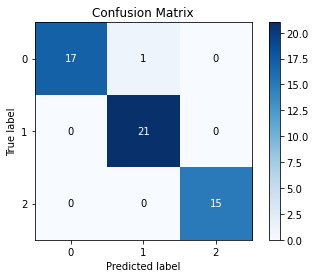

In [13]:
# l'accuratezza ottenuta è molto buona 
# ma stampo comunque una matrice di confusione per avere una visione più chiara degli errori

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=False)
plt.show()

Vediamo che è stata sbagliata una sola predizione (un campione della classe 0 è stato assegnato alla classe 1).
Mi posso quindi ritenere soddisfatto del risultato raggiunto.